# Compare and Difference Model Run with Upscaled ASO Data

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rasterio as rio
from rasterio import plot, mask, features
import rioxarray 
import hvplot.xarray 
from rasterio.warp import reproject, Resampling
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import mapping

In [2]:
# set temperature threshold. choices: [0,1,2]
threshold = 0
# set day. choices: ['20160329','20160208']
day_str = '20160329'
# set stat. choices: [0,1,2,3,4] represent ensemble [mean,std,median,25%,75%]
stat = 2

In [3]:
# set DOWY
if day_str == '20160329':
    day_num = 180
elif day_str == '20160208':
    day_num = 130
else:
    print('Invalid date')

In [4]:
print(f'Temperature Threshold = {threshold}K, Day = {day_str}, DOWY = {day_num}.')

Temperature Threshold = 0K, Day = 20160329, DOWY = 180.


In [5]:
#open model run netcdf
xds = xr.open_dataset(f"../SnowHydro/data/Model_Output/{threshold}K_Threshold/N47_0W124_0_agg_16_SWE_SCA_POST_WY2015_16.nc")
#xds

In [6]:
# select the day and stat we want from the model run, set spatial dimensions, and set crs
model_ds = xds['SWE_Post'].sel(Day=day_num,Stats=stat).T
model_ds.rio.set_spatial_dims('Longitude','Latitude',inplace=True)
model_ds.rio.set_crs('EPSG:4326',inplace=True);

In [7]:
# open ASO dataset, check crs
ASO_500m_ds = xr.open_rasterio(f'data/Olympics_ASO_SWE_2016/ASO_500m_SWE_USAWOL_{day_str}.tif')

Text(0.5, 0.98, 'Pre Reproject Match Comparison')

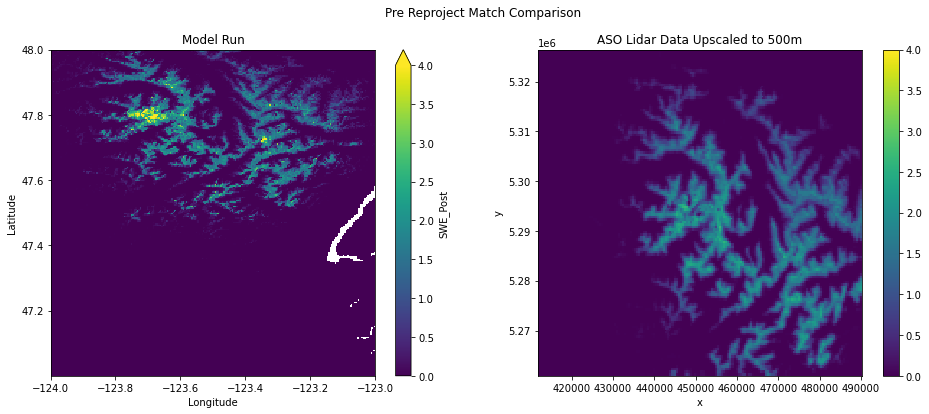

In [8]:
# comparing before reproject
f,ax = plt.subplots(1,2,figsize=(16,6))
model_ds.plot(ax=ax[0],vmin=0,vmax=4)
ax[0].set_title('Model Run')
ASO_500m_ds.plot(ax=ax[1],vmin=0,vmax=4)
ax[1].set_title('ASO Lidar Data Upscaled to 500m')
f.suptitle('Pre Reproject Match Comparison')

In [9]:
# mask out glaciers
glaciers_gdf = gpd.read_file('data/Glacier_shapefiles/glims_polygons.shp')
model_clipped = model_ds.rio.clip(glaciers_gdf.geometry.apply(mapping), glaciers_gdf.crs, drop=False,invert=True) # set invert True when looking at NON-glaciers

In [10]:
# reprojecting
model_reproject_glacma = model_clipped.rio.reproject_match(ASO_500m_ds)
model_reproject = model_ds.rio.reproject_match(ASO_500m_ds)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Text(0.5, 0.98, 'Post Reproject Match Comparison')

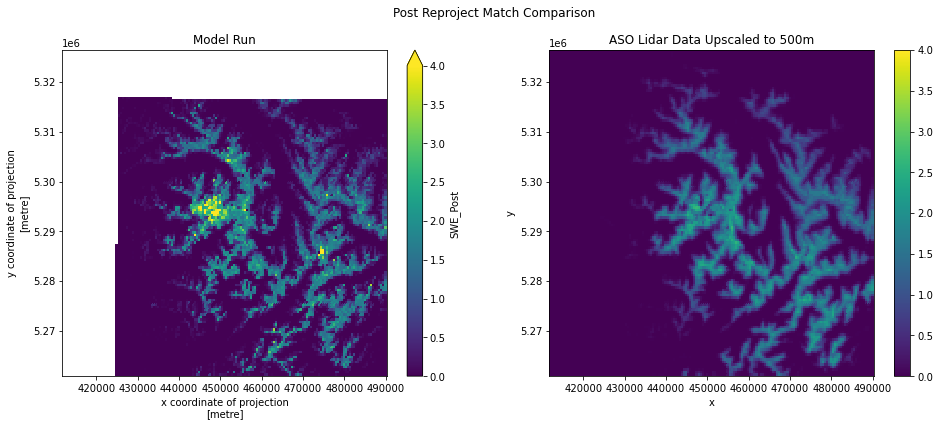

In [11]:
# post projection comparison
f, ax = plt.subplots(1,2,figsize=(16,6))
model_reproject.plot(ax=ax[0],vmin=0,vmax=4)
ax[0].set_title('Model Run')
ASO_500m_ds.plot(ax=ax[1],vmin=0,vmax=4)
ax[1].set_title('ASO Lidar Data Upscaled to 500m')
f.suptitle('Post Reproject Match Comparison')

In [14]:
# difference
model_reproject = model_reproject.sel(x=slice(4.3e5,4.9e5),y=slice(5.315e6,5.26e6))
model_reproject_glacma = model_reproject_glacma.sel(x=slice(4.3e5,4.9e5),y=slice(5.315e6,5.26e6))
ASO_500m_ds = ASO_500m_ds.sel(x=slice(4.3e5,4.9e5),y=slice(5.315e6,5.26e6))
difference =  model_reproject - ASO_500m_ds
difference_glacma =  model_reproject_glacma - ASO_500m_ds 

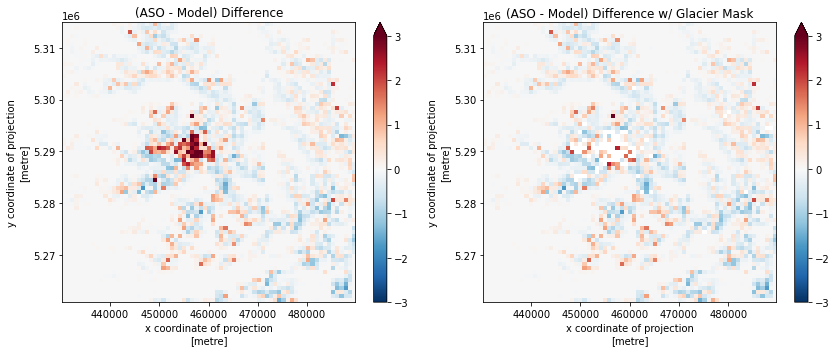

In [15]:
# show difference
f, ax = plt.subplots(1,2,figsize=(12,5))
difference.squeeze().plot.imshow(ax=ax[0],vmin=-3,vmax=3,cmap='RdBu_r',interpolation='none')
difference_glacma.squeeze().plot.imshow(ax=ax[1],vmin=-3,vmax=3,cmap='RdBu_r',interpolation='none')
ax[0].set_title('(ASO - Model) Difference')
ax[1].set_title('(ASO - Model) Difference w/ Glacier Mask')
plt.tight_layout()

Text(0.5, 0.98, 'Model and ASO Lidar Differencing on DOWY = 180 with Temperature Threshold = 0K')

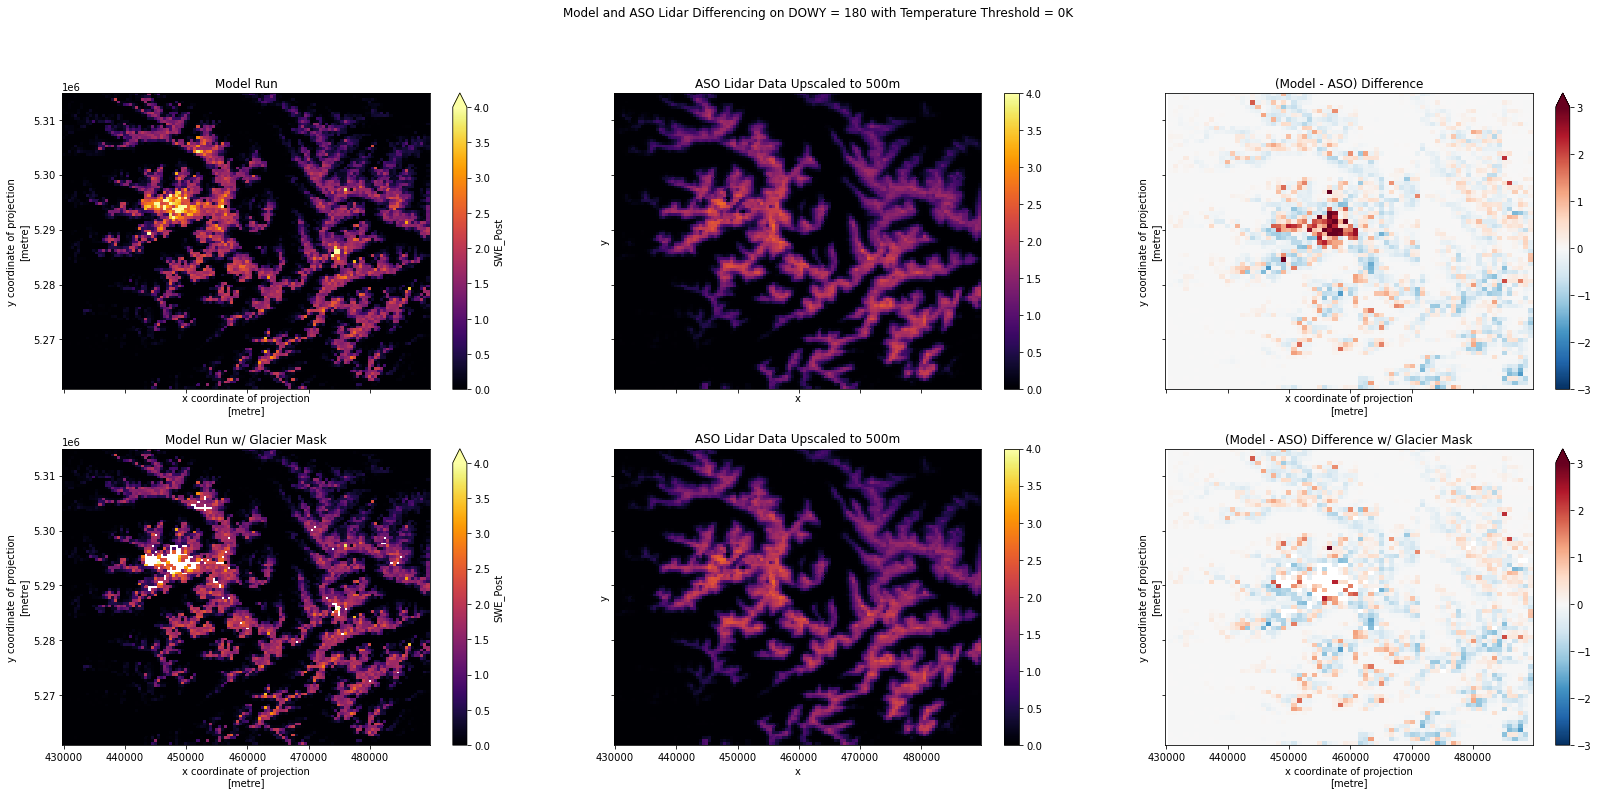

In [18]:
# plot differencing
f, ax = plt.subplots(2,3,figsize=(28,12),sharex=True,sharey=True) 
model_reproject.plot(ax=ax[0,0],vmin=0,vmax=4,cmap='inferno')
ax[0,0].set_title('Model Run')
ASO_500m_ds.plot(ax=ax[0,1],vmin=0,vmax=4,cmap='inferno')
ax[0,1].set_title('ASO Lidar Data Upscaled to 500m')
difference.squeeze().plot.imshow(ax=ax[0,2],vmin=-3,vmax=3,cmap='RdBu_r')
ax[0,2].set_title('(Model - ASO) Difference')

model_reproject_glacma.plot(ax=ax[1,0],vmin=0,vmax=4,cmap='inferno')
ax[1,0].set_title('Model Run w/ Glacier Mask')
ASO_500m_ds.plot(ax=ax[1,1],vmin=0,vmax=4,cmap='inferno')
ax[1,1].set_title('ASO Lidar Data Upscaled to 500m')
difference_glacma.squeeze().plot.imshow(ax=ax[1,2],vmin=-3,vmax=3,cmap='RdBu_r')
ax[1,2].set_title('(Model - ASO) Difference w/ Glacier Mask')
f.suptitle(f'Model and ASO Lidar Differencing on DOWY = {day_num} with Temperature Threshold = {threshold}K')
#for i in range(len(ax)):
#    ax[i].set_xlim([431000, 490000])
#    ax[i].set_ylim([5.262e6, 5.31e6])
#    ax[i].add_artist(ScaleBar(1.0))


In [ ]:
# Now Mask the Glaciers

In [ ]:
#glaciers_gdf = gpd.read_file('data/Glacier_shapefiles/glims_polygons.shp')
#glaciers_gdf_proj = glaciers_gdf.to_crs('EPSG:32610')
#clipped = difference.rio.clip(glaciers_gdf_proj.geometry.apply(mapping), glaciers_gdf_proj.crs, drop=False,invert=False) # set invert True when looking at NON-glaciers

In [ ]:
#f,ax = plt.subplots(1,2,figsize=(10,5))
#glaciers_gdf.plot(ax=ax[0])
#ax[0].set_title(f'Glacier Mask {glaciers_gdf.crs}')
#glaciers_gdf_proj.plot(ax=ax[1])
#ax[1].set_title(f'Glacier Mask {glaciers_gdf_proj.crs}')
#plt.tight_layout()

In [ ]:
#f,ax = plt.subplots(1,3,figsize=(20,6),sharey=True,sharex=True)

#glaciers_gdf_proj.plot(ax=ax[0])
#ax[0].set_title(f'Glacier Mask {glaciers_gdf_proj.crs}')
#difference.squeeze().plot.imshow(ax=ax[1],vmin=-3,vmax=3,cmap='RdBu_r',interpolation='none')
#ax[1].set_title(f'Raster {difference.rio.crs}')
#clipped.squeeze().plot.imshow(ax=ax[2],vmin=-3,vmax=3,cmap='RdBu_r',interpolation='none') # changed vmin and vmax to show masked area clearly
#ax[2].set_title(f'(ASO - Model Difference) {clipped.rio.crs}')
#plt.tight_layout()
#for i in range(len(ax)):
#    ax[i].set_xlim([431000, 490000])
#    ax[i].set_ylim([5.262e6, 5.31e6])
#    ax[i].add_artist(ScaleBar(1.0))

In [ ]:
#import salem

In [ ]:
#shdf = salem.read_shapefile('data/Glacier_shapefiles/glims_polygons.shp')

In [ ]:
#difference

In [ ]:
#difference.salem.quick_map()

In [ ]:
#glacier_sub = difference.squeeze().salem.subset(shape=shdf, margin=2)  # add 2 grid points

In [ ]:
"""
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    
    transform = transform_from_latlon(coords['latitude'], coords['longitude'])
    out_shape = (len(coords['latitude']), len(coords['longitude']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xray.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))

# this shapefile is from natural earth data
# http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
#states = geopandas.read_file('/Users/shoyer/Downloads/ne_10m_admin_1_states_provinces_lakes')
#us_states = states.query("admin == 'United States of America'").reset_index(drop=True)
glaciers_gdf = gpd.read_file('data/Glacier_shapefiles/glims_polygons.shp')
glacier_ids = {k: i for i, k in enumerate(glaciers_gdf.woe_name)}
shapes = [(shape, n) for n, shape in enumerate(glaciers_gdf.geometry)]

#ds = xray.Dataset(coords={'longitude': np.linspace(-125, -65, num=5000),
#                          'latitude': np.linspace(50, 25, num=3000)})
difference['states'] = rasterize(shapes, difference.coords)

# example of applying a mask
ds.states.where(ds.states == state_ids['California']).plot()
"""

In [ ]:
#glacier_geom = glaciers_gdf_proj.geometry

In [ ]:
#glacier_geom

In [ ]:
#glacier_bounds = glacier_geom.total_bounds
#glacier_bounds

In [ ]:
#def myround(x, base=0.25):
#    return base * np.round(x/base)

#def roundbounds(bounds, base=0.25):
#    bounds_floor = np.floor(bounds/base)*base
#    bounds_ceil = np.ceil(bounds/base)*base
#    return [bounds_floor[0], bounds_floor[1], bounds_ceil[2], bounds_ceil[3]]

In [ ]:
#glacier_rbounds = roundbounds(glacier_bounds)
#glacier_rbounds

In [ ]:
#difference_masked_glaciers = difference.sel(y=slice(glacier_rbounds[3],glacier_rbounds[1]), x=slice(glacier_rbounds[0],glacier_rbounds[2]))

In [ ]:
#f, ax = plt.subplots()
#difference_masked_glaciers.squeeze().plot.imshow(ax=ax,vmin=-3,vmax=3,cmap='RdBu_r')

In [ ]:
#difference.coords

In [ ]:
#difference.reset_index('band').reset_coords(drop=True).coords

In [ ]:
#raster = features.rasterize(glacier_geom,difference.reset_index('band').reset_coords(drop=True).coords)

In [ ]:
#rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}

In [ ]:
#glacier_ma, glacier_ma_transform = rio.mask.mask(difference.to_masked_array(), glacier_geom, **rio_mask_kwargs)

In [ ]:
#whidbey_ma, whidbey_out_transform = rio.mask.mask(src_proj, [whidbey_geom,], filled=False, crop=True, indexes=1)
#whidbey_ma_extent = rio.plot.plotting_extent(whidbey_ma, whidbey_out_transform)

In [ ]:
#color = ax.imshow(whidbey_ma, extent=whidbey_ma_extent,alpha=0.8,cmap='inferno');